In [1]:
import devito as dv
import sympy as sp

In [2]:
grid = dv.Grid(shape=(201, 201), extent=(1., 1.))
p = dv.TimeFunction(name='p', grid=grid, space_order=2)
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=2, staggered=(None, None))
vx, vy = v

# Material parameters
c = dv.Function(name='c', grid=grid, space_order=2)
rho = dv.Function(name='rho', grid=grid, space_order=2)
c.data[:] = 1.
rho.data_with_halo[:] = 1. # Encountering zeros in the halo here is bad

# Define bouyancy for shorthand
b = 1/rho
# Define square celerity for shorthand
c2 = c**2  # FIXME: This prints missing the ^2 (string does contain **2 however)

In [3]:
dv.grad(1/p)

Vector(Derivative(1/p(t, x, y), x), Derivative(1/p(t, x, y), y))

In [4]:
dt = grid.stepping_dim.spacing
dt

dt

In [5]:
# For setting up the 2nd-order ADER scheme

# First time derivatives
pdt = rho*c2*dv.div(v)
vdt = b*dv.grad(p)

# Second time derivatives
pdt2 = rho*c2*(dv.grad(b).dot(dv.grad(p)) + b*p.laplace)
# dv.grad(dv.div(v)) does not get flattened and will need to be explicitly written out
graddivv = sp.Matrix([[vx.dx2 + vx.dxdy],
                      [vy.dxdy + vy.dy2]])
# vdt2 = b*(dv.grad(rho)*c2*dv.div(v) + rho*dv.grad(c2)*dv.div(v) + rho*c2*dv.grad(dv.div(v)))
vdt2 = b*(dv.grad(rho)*c2*dv.div(v) + rho*dv.grad(c2)*dv.div(v) + rho*c2*graddivv)
vdt2

Vector(((Derivative(v_x(t, x, y), x) + Derivative(v_y(t, x, y), y))*c(x, y)**2*Derivative(rho(x, y), x) + (Derivative(v_x(t, x, y), x) + Derivative(v_y(t, x, y), y))*rho(x, y)*Derivative(c(x, y)**2, x) + (Derivative(v_x(t, x, y), (x, 2)) + Derivative(v_x(t, x, y), x, y))*c(x, y)**2*rho(x, y))/rho(x, y), ((Derivative(v_x(t, x, y), x) + Derivative(v_y(t, x, y), y))*c(x, y)**2*Derivative(rho(x, y), y) + (Derivative(v_x(t, x, y), x) + Derivative(v_y(t, x, y), y))*rho(x, y)*Derivative(c(x, y)**2, y) + (Derivative(v_y(t, x, y), (y, 2)) + Derivative(v_y(t, x, y), x, y))*c(x, y)**2*rho(x, y))/rho(x, y))

In [6]:
# Update equations (2nd-order ADER timestepping)
eq_p = dv.Eq(p.forward, p + dt*pdt + (dt**2/2)*pdt2)
eq_v = dv.Eq(v.forward, v + dt*vdt + (dt**2/2)*vdt2)

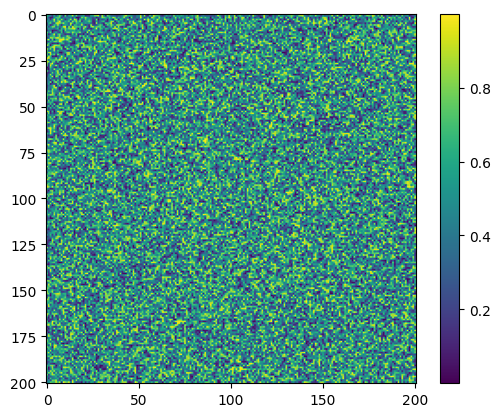

116.20304


Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.008284999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [7]:
# Try initialising with white noise and running for 20 timesteps to check stability
import numpy as np
import matplotlib.pyplot as plt

p.data[:] = np.random.rand(*p.shape)
vx.data[:] = np.random.rand(*vx.shape)
vy.data[:] = np.random.rand(*vy.shape)

plt.imshow(p.data[-1])
plt.colorbar()
plt.show()

print(np.linalg.norm(p.data[-1]))

op = dv.Operator([eq_p, eq_v])
op.apply(t_M=100, dt=0.005*grid.spacing[0])

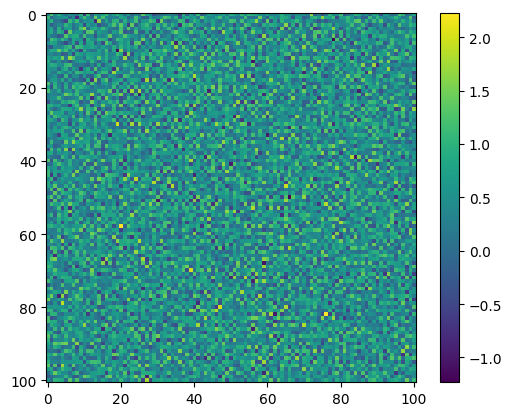

143.02028


In [9]:
plt.imshow(p.data[-1, 50:-50, 50:-50])
plt.colorbar()
plt.show()

print(np.linalg.norm(p.data[-1]))

Operator `Kernel` ran in 0.02 s


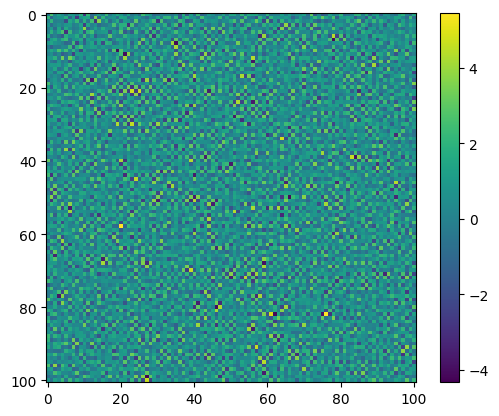

290.8405


In [10]:
op.apply(t_M=100, dt=0.005*grid.spacing[0])

plt.imshow(p.data[-1, 50:-50, 50:-50])
plt.colorbar()
plt.show()

print(np.linalg.norm(p.data[-1]))

In [ ]:
# Check maths and figure out why there is instability here
# Have I possibly calculated the second time derivatives wrong?
# Definitely a grid-grid decoupling, since amplitude range gets more symmetric over time
# The scheme should be slightly diffusive (decreasing norms)